# generalized Polynomial Chaos Expansion (gPCE)

Saleh Rezaeiravesh, salehr@kth.se <br/>
SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden

The aim of this notebook is to show how to use `UQit` for non-intrusive gPCE. In practice, we have the parameter samples and associated values of the model response. Therefore, we only want to construct the PCE and estimate statistical moments of the model funtion due to the variablity of the uncertain parameters. This basically means much of the coding in the following examples is not required. Here, the extensive examples are provided to validate the implementation of the gPCE in `UQit` for different combinations of parameters as well as different parameter dimensions. The validation is achieved through comparing the moments estimated by PCE with the reference values obtained wither from analytical expressions or standard Monte-Carlo method. 

In [1]:
import os
import sys
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
sys.path.append(os.getenv("UQit"))
import pce
import analyticTestFuncs
import writeUQ
import reshaper
import sampling

### Example 1: gPCE for a parameter with uniform distribution
Consider a model function $f(q)$, where $q\sim\mathcal{U}[a,b]$. The aim is to apply gPCE to estimate $\mathbb{E}_q[f(q)]$ and $\mathbb{V}_q[f(q)]$ and also construct a surrogate $\tilde{f}(q)$. 

In particular, we consider 
$$
\begin{equation}
r=10+0.7\sin(5q)+3 \cos(q)
\end{equation}
$$

which is implemented in `analyticTestFuncs.fEx1D(qNodes,'type1')`. The exact values of the mean and variance of this test function can be computed analytically and be used to validate the PCE estimations. 

**Step 1:** Set the general settings

In [2]:
distType='Unif'   #distribution type of the parameter
qInfo=[-2,4.0]    #parameter admissible range
n=10              #number of training samples
nTest=200         #number of test samples in the parameter space

Set the PCE settings; we assume the training samples are in the form of Gauss-Legendre nodes. The PCE coeffcients are to be obtained by the `Projection` method. Alternatively one can choose the `Regression` method.

In [3]:
sampleType='GQ'    #'GQ'=Gauss Quadrature nodes
                   #''= any other sample => only 'Regression' can be selected
pceSolveMethod='Projection' #'Regression': for any combination of sample points 
                            #'Projection': only for GQ

**Step 2:** Put together the PCE information in `pceDict`. If some of the options are wrongly set by the user, `pceDict_corrector` will correct it. 

In [4]:
pceDict={'p':1,'sampleType':sampleType,'pceSolveMethod':pceSolveMethod,'distType':[distType]}

**Step 3:** Generate training samples. We choose the samples to be Gauss-Legendre nodes. Note that samples $\{q^{(i)}\}_{i=1}^n \in \mathbb{Q}$ where $\mathbb{Q}$ is `qInfo`, the admissible range of the parameter. Based on the gPCE rule, the polynomial bases are Legendre polynomials defined over the mapped space $\Gamma=[-1,1]$. Therefore corresponding to each $q^{(i)}$, there is a unique $\xi^{(i)}\in\Gamma$.

In [5]:
samps=sampling.trainSample(sampleType=sampleType,GQdistType=distType,qInfo=qInfo,nSamp=n)
q=samps.q       #training samples in the original parameter space
xi=samps.xi     #training samples in the mapped parameter space
qBound=samps.qBound  #admissible range of the parameter

**Step 4:** Run the simulators at the training samples. 

In [6]:
fEx=analyticTestFuncs.fEx1D(q,'type1',qInfo)
f=fEx.val

**Step 5** Construct the PCE, given the training data.

In [7]:
pce_=pce.pce(fVal=f,xi=xi[:,None],pceDict=pceDict)
fMean=pce_.fMean     #E[f(q)] estimated by PCE
fVar=pce_.fVar       #V[f(q)] estimated by PCE
pceCoefs=pce_.coefs  #Coefficients of the PCE

The outputs are the coefficients in the PCE along with the estimated $\mathbb{E}_q[f(q)]$ and  $\mathbb{V}_q[f(q)]$. 

Compute the exact moments of f(q), as the reference values

In [8]:
fEx.moments(qInfo)
fMean_ex=fEx.mean
fVar_ex=fEx.var

**Step 6:** Validate the PCE_estimated moments with associated analytical values. 

In [9]:
print('--------- Exact --------- PCE ---- Error % ')
print('E[(q)] = %g\t%g\t%g' %(fMean_ex,fMean,(fMean-fMean_ex)/fMean_ex*100.))
print('V[f(q)] = %g\t%g\t%g' %(fVar_ex,fVar,(fVar-fVar_ex)/fVar_ex*100.))

--------- Exact --------- PCE ---- Error % 
E[(q)] = 10.0471	10.056	0.0882092
V[f(q)] = 4.91876	5.05353	2.73999


Plot the convergence of the PCE terms

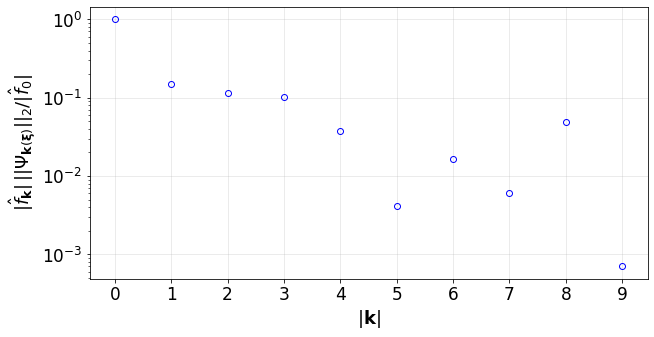

In [10]:
pce.convPlot(coefs=pceCoefs,distType=distType)

**Step 7:** Visually comapre the PCE surrogate with the actual simulator at a set of test samples taken from the considered parameter range. First, we generate test points and the value of the simulator. 

In [11]:
testSamps=sampling.testSample('unifSpaced',GQdistType=distType,qInfo=qInfo,qBound=qBound,nSamp=nTest)
qTest=testSamps.q
xiTest=testSamps.xi
fTest=analyticTestFuncs.fEx1D(qTest,'type1',qInfo).val   #exact response at test samples

Evaluate the constructed PCE at the test points.

In [12]:
pcePred_=pce.pceEval(coefs=pceCoefs,xi=[xiTest],distType=[distType])
fPCE=pcePred_.pceVal

Plot the PCE and exact values:

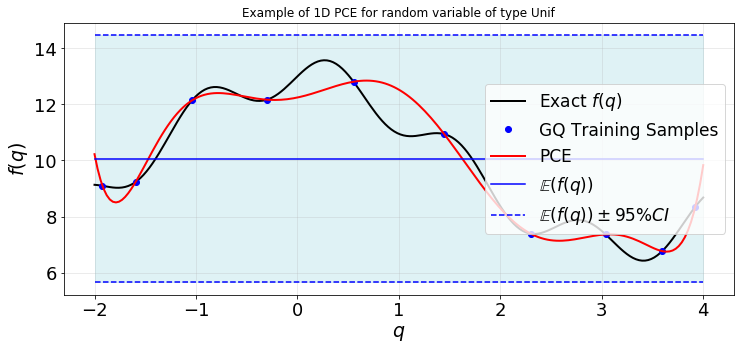

In [13]:
def plot1d(qTest,fTest,q,f,fPCE,fMean,fVar):
    plt.figure(figsize=(12,5))
    ax=plt.gca()
    plt.plot(qTest,fTest,'-k',lw=2,label=r'Exact $f(q)$')
    plt.plot(q,f,'ob',label=sampleType+' Training Samples')
    plt.plot(qTest,fPCE,'-r',lw=2,label='PCE')
    plt.plot(qTest,fMean*np.ones(len(qTest)),'-b',label=r'$\mathbb{E}(f(q))$')
    ax.fill_between(qTest,fMean+1.96*mt.sqrt(fVar)*np.ones(len(qTest)),fMean-1.96*mt.sqrt(fVar)*np.ones(len(qTest)),color='powderblue',alpha=0.4)
    plt.plot(qTest,fMean+1.96*mt.sqrt(fVar)*np.ones(len(qTest)),'--b',label=r'$\mathbb{E}(f(q))\pm 95\%CI$')
    plt.plot(qTest,fMean-1.96*mt.sqrt(fVar)*np.ones(len(qTest)),'--b')
    plt.title('Example of 1D PCE for random variable of type %s' %distType)
    plt.xlabel(r'$q$',fontsize=19)
    plt.ylabel(r'$f(q)$',fontsize=19)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.grid(alpha=0.3)
    plt.legend(loc='best',fontsize=17)
    
plot1d(qTest,fTest,q,f,fPCE,fMean,fVar)    

### Example 2: gPCE for a parameter with uniform distribution
Repeat Example 1, with parameter samples chosen not as Gauss-Legendre nodes. Also use total-order truncation scheme. For this settings the regression method is used to compute the PCE coefficients. The distribution type and admissible range of the parameter are the same as the previous example.

In [14]:
n=30              #number of training samples
#PCE Settings
sampleType='unifRand'                     
pceSolveMethod='Regression' 
LMax=40       #maximum polynomial order in total-order truncation

In [15]:
#(0) Make the pceDict
pceDict={'p':1,'sampleType':sampleType,'pceSolveMethod':pceSolveMethod,'LMax':LMax,
         'distType':[distType]}
#(1) Generate training data
samps=sampling.trainSample(sampleType=sampleType,GQdistType=distType,qInfo=qInfo,nSamp=n)
q=samps.q
xi=samps.xi
qBound=samps.qBound
fEx=analyticTestFuncs.fEx1D(q,'type1',qInfo)
f=fEx.val
#(2) Construct the PCE
pce_=pce.pce(fVal=f,xi=xi[:,None],pceDict=pceDict)
fMean=pce_.fMean     #E[f(q)] estimated by PCE
fVar=pce_.fVar       #V[f(q)] estimated by PCE
pceCoefs=pce_.coefs  #Coefficients in the PCE

...... Number of terms in PCE, K=  40
...... Number of Data point, n=  30
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 80, constraints m = 120
          nnz(P) + nnz(A) = 1760
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.2000e+02   3.07e+02   1.48e+05   1.00e-01   2.46e-04s
 200   2.6757e+01   1.76e-02   4.

Not that if `LMax` is chosen to be bigger than `n`, then compressed sensing is called which may happen that does not converge.

In [16]:
#(3) Compare moments: exact vs. PCE estimations
print('-------------- Exact -------- PCE --------- Error % ')
print('Mean of f(q) = %g\t%g\t%g' %(fMean_ex,fMean,(fMean-fMean_ex)/fMean_ex*100.))
print('Var  of f(q) = %g\t%g\t%g' %(fVar_ex,fVar,(fVar-fVar_ex)/fVar_ex*100.))

-------------- Exact -------- PCE --------- Error % 
Mean of f(q) = 10.0471	9.36055	-6.8338
Var  of f(q) = 4.91876	4.28465	-12.8916


Plot the convergence of the PCE terms

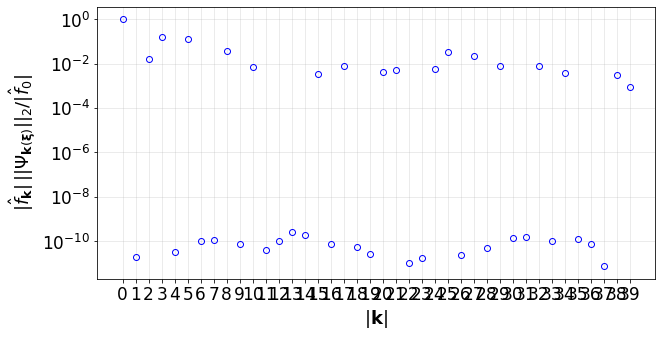

In [17]:
pce.convPlot(coefs=pceCoefs,distType=distType)

Plot the response surface

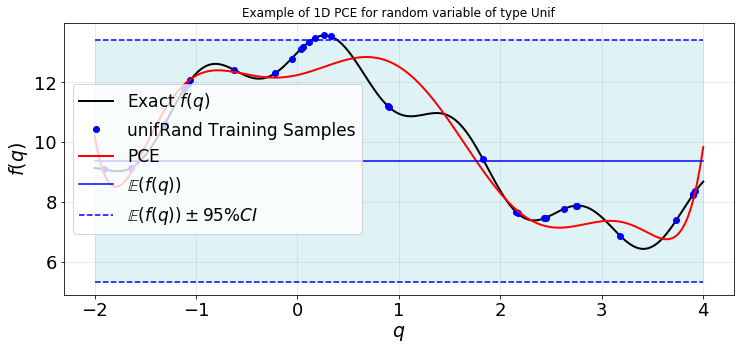

In [18]:
plot1d(qTest,fTest,q,f,fPCE,fMean,fVar) 

You can compare the accuracy of the estimated moments of $f(q)$ and the response function to what we get from Example 1.

**Further Practice:**
1. Try to change the number of trainging samples and look at the convergence of the moments and above figure. 
2. Change `LMax` and see how it impacts the outputs.
3. Try different types of training samples `unifSpaced`, `GLL`, `unifRand`, ...

### Example 3: gPCE for a parameter with Gaussian distribution
Consider $q\sim\mathcal{N}(m,v^2)$, where $m$ and $v$ are known and constant. We wan to use gPCE method to estimate the mean and variance of the following model function, 

$$
f(q)=\cos(m(q-m))
$$

which is implemented in `analyticTestFuncs.fEx1D(q,'type2')`. The exact values of the mean and variance of this test function can be computed analytically and be used to validate the PCE estimations. 

In [19]:
#Settings
distType='Norm'      #distribution type of the parameter
qInfo=[2,0.9]       #[m,v] for 'Norm' q~N(m,v^2)
#PCE settings
n=15                 #number of training samples
nTest=200            #number of test sample sin the parameter space
sampleType='GQ'      #'GQ'=Gauss Quadrature nodes
                     #'normRand'= Random samples from the given Gaussian distribution
                     # see `trainSample` class in sampling.py
pceSolveMethod='Projection' #'Regression': for any combination of sample points 
                            #'Projection': only for GQ
LMax_=50            #(Only used Regresson method)

In [20]:
#(0) Make the pceDict
pceDict={'p':1,'sampleType':sampleType,'pceSolveMethod':pceSolveMethod,'LMax':LMax_,
        'distType':[distType]}
#(1) Generate training data
samps=sampling.trainSample(sampleType=sampleType,GQdistType=distType,qInfo=qInfo,nSamp=n)
q=samps.q
xi=samps.xi
qBound=samps.qBound
fEx=analyticTestFuncs.fEx1D(q,'type2',qInfo)
f=fEx.val
#(2) Compute the exact moments (as the reference data)
fEx.moments(qInfo)
fMean_ex=fEx.mean
fVar_ex=fEx.var
#(3) Construct the PCE
pce_=pce.pce(fVal=f,xi=xi[:,None],pceDict=pceDict)
fMean=pce_.fMean     #E[f(q)] estimated by PCE
fVar=pce_.fVar       #V[f(q)] estimated by PCE
pceCoefs=pce_.coefs  #Coefficients in the PCE

Compare moments: exact vs. PCE estimations

In [21]:
print('-------------- Exact -------- PCE --------- Error % ')
print('Mean of f(q) = %g\t%g\t%g' %(fMean_ex,fMean,(fMean-fMean_ex)/fMean_ex*100.))
print('Var  of f(q) = %g\t%g\t%g' %(fVar_ex,fVar,(fVar-fVar_ex)/fVar_ex*100.))

-------------- Exact -------- PCE --------- Error % 
Mean of f(q) = 0.197899	0.197899	5.15003e-11
Var  of f(q) = 0.461603	0.461608	0.00111709


Convergence of the PCE terms

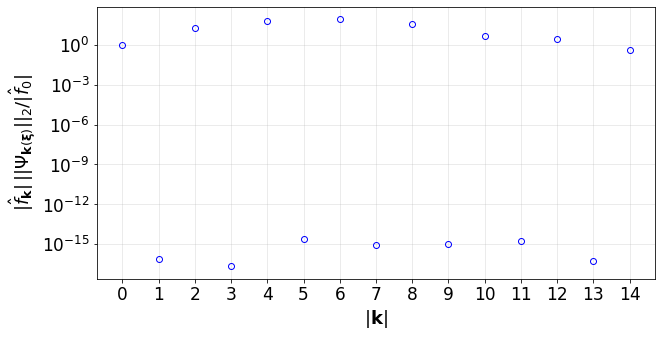

In [22]:
pce.convPlot(coefs=pceCoefs,distType=distType)

Evaluate the PCE at test samples and plot the response surface

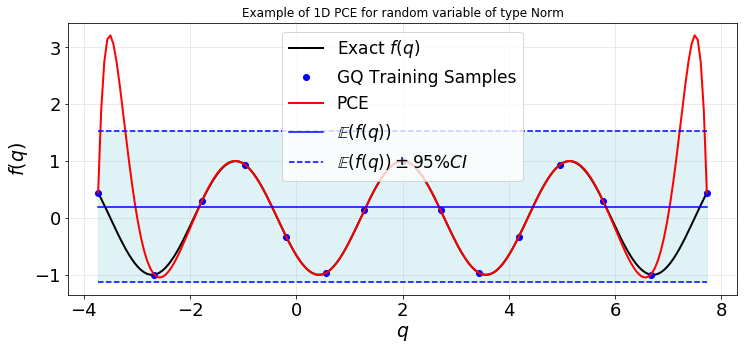

In [23]:
testSamps=sampling.testSample('unifSpaced',GQdistType=distType,qInfo=qInfo,qBound=qBound,nSamp=nTest)
qTest=testSamps.q
xiTest=testSamps.xi
fTest=analyticTestFuncs.fEx1D(qTest,'type2',qInfo).val   #exact response at test samples
#Prediction by PCE at test samples
pcePred_=pce.pceEval(coefs=pceCoefs,xi=[xiTest],distType=[distType])
fPCE=pcePred_.pceVal
#plot
plot1d(qTest,fTest,q,f,fPCE,fMean,fVar) 

Note that despite the descrepancy between the PCE and exact response surface, the mean and variance of the model function can be estimated accurately by the PCE. 

### Example 4: gPCE for 2 parameters with different distributions
Let $q_1$ and $q_2$ be two independent uncertain parameters with known type of distributions. Also, consider a model function $f(q_1,q_2)$ as the simulator. In `analyticTestFuncs.fEx2D(q1,q2,typ,method)` for `typ` equal to `'type1'`, `'type2'`, `'type3'`, and `'Rosenbrock'`, we have different functional form implemented for $f(q_1,q_2)$. 
We use `UQit` to construct a gPCE over the tensor-product space $\mathbb{Q}_1\bigotimes \mathbb{Q}_2$. The mean and varaiance of $f(q_1,q_2)$ estimated by gPCE compared to the values by pure Monte-Carlo method. 

First, we set the specifications of the parameters and the options for PCE. It is recalled that if a parameter is uniformly distributed, then `qInfo` specifies the admissible range $\mathbb{Q}$ of that parameter. But, if a parameter is Gaussian, then `qInfo=[m,v]` corresponds to $\mathcal{N}(m,v^2)$.

In [24]:
#Parameters specifications
distType=['Unif','Norm']   #distribution type of the parameters q1, q2
qInfo=[[-2,3],             #info on parameters
       [-2,0.4]]
nQ=[10,9]                   #number of training samples of parameters 
nTest=[121,120]            #number of test points in parameter spaces to evaluate PCE
#PCE Options
truncMethod='TO'     #'TP'=Tensor Product
                     #'TO'=Total Order  
sampleType=['GQ','GQ']  #'GQ'=Gauss Quadrature nodes ('Projection' or 'Regression')
                        #For other type of samples, see sampling.py, trainSample => only 'Regression' can be used
                        #'LHS': Latin Hypercube Sampling (only when all distType='Unif')
fType='type1'#Type of the exact model response, 'type1', 'type2', 'type3', 'Rosenbrock'
pceSolveMethod='Regression' #'Regression': for any combination of sampling and truncation methods
                            #'Projection': only for 'GQ'+'TP'
if truncMethod=='TO':
   LMax=9   #max polynomial order in each parameter dimention

Assemble the pce dict

In [25]:
p=len(distType)
pceDict={'p':p,'truncMethod':truncMethod,'sampleType':sampleType,
            'pceSolveMethod':pceSolveMethod,'distType':distType}
if truncMethod=='TO':
   pceDict.update({'LMax':LMax,'pceSolveMethod':'Regression'})

Generate the training data

In [26]:
q=[]
xi=[]
qBound=[]
for i in range(p):
    samps=sampling.trainSample(sampleType=sampleType[i],
                   GQdistType=distType[i],qInfo=qInfo[i],nSamp=nQ[i])
    q.append(samps.q)
    xi.append(samps.xi)
    qBound.append(samps.qBound)
fEx_=analyticTestFuncs.fEx2D(q[0],q[1],fType,'tensorProd')
fVal=fEx_.val
xiGrid=reshaper.vecs2grid(xi)

Construct the PCE

In [27]:
pce_=pce.pce(fVal=fVal,xi=xiGrid,pceDict=pceDict,nQList=nQ)
fMean=pce_.fMean
fVar=pce_.fVar
pceCoefs=pce_.coefs
kSet=pce_.kSet

... A gPCE for a 2-D parameter space is constructed.
...... PCE truncation method: TO
...... Method of computing PCE coefficients: Regression
         with LMax=9 as the max polynomial order in each direction.
...... Number of terms in PCE, K=  55
...... Number of Data point, n=  90
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 110, constraints m = 165
          nnz(P) + nnz(A) = 3217
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: of

Plot the convergence indicator of the PCE

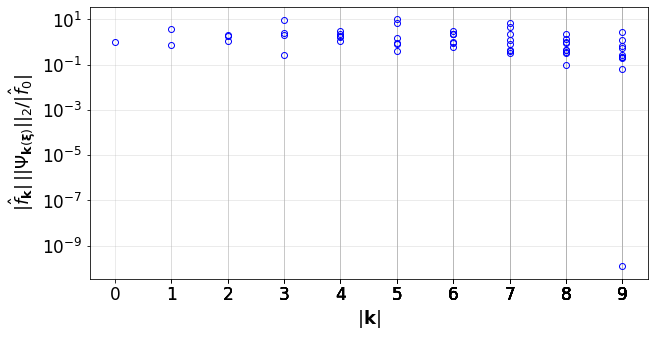

In [28]:
pce.convPlot(coefs=pceCoefs,distType=distType,kSet=kSet)

Use MC method to directly estimate reference values for the mean and varaiance of f(q) 

In [29]:
fEx_.moments(distType,qInfo)
fMean_mc=fEx_.mean
fVar_mc=fEx_.var

... Reference moments are calculated by the Monte-Carlo method with 100000 samples


Generate test samples for the parameters and evaluate the exact response surface and the constructed PCE at them

In [30]:
def testSamps2d(p,distType,qInfo,qBound,nTest):
    qTest=[]
    xiTest=[]
    for i in range(p):
        testSamps=sampling.testSample('unifSpaced',GQdistType=distType[i],
                    qInfo=qInfo[i],qBound=qBound[i],nSamp=nTest[i])
        qTest_=testSamps.q
        xiTest_=testSamps.xi
        qTest.append(qTest_)
        xiTest.append(xiTest_)
    fTest=analyticTestFuncs.fEx2D(qTest[0],qTest[1],fType,'tensorProd').val
    return xiTest,qTest,fTest    
xiTest,qTest,fTest=testSamps2d(p,distType,qInfo,qBound,nTest)
#Evaluate PCE at the test samples
pcePred_=pce.pceEval(coefs=pceCoefs,xi=xiTest,distType=distType,kSet=kSet)
fPCE=pcePred_.pceVal

Compare the PCE estimates for moments of f(q) with the reference values from MC

In [31]:
print('------------ MC -------- PCE --------- Error % ')
print('Mean of f(q) = %g\t%g\t%g' %(fMean_mc,fMean,(fMean-fMean_mc)/fMean_mc*100.))
print('Var  of f(q) = %g\t%g\t%g' %(fVar_mc,fVar,(fVar-fVar_mc)/fVar_mc*100.))

------------ MC -------- PCE --------- Error % 
Mean of f(q) = -0.516505	-0.504892	-2.24822
Var  of f(q) = 3.72742	3.54174	-4.98162


Clearly, we see how the use of gPCE with much fewer number of samples (and hence running the simulator) compared to Monte-carlo appraoch will result in the accuracte estimates for the $\mathbb{E}[f(q_1,q_2)]$ and $\mathbb{V}[f(q_1,q_2)]$.

Make contour plots of the response surfaces

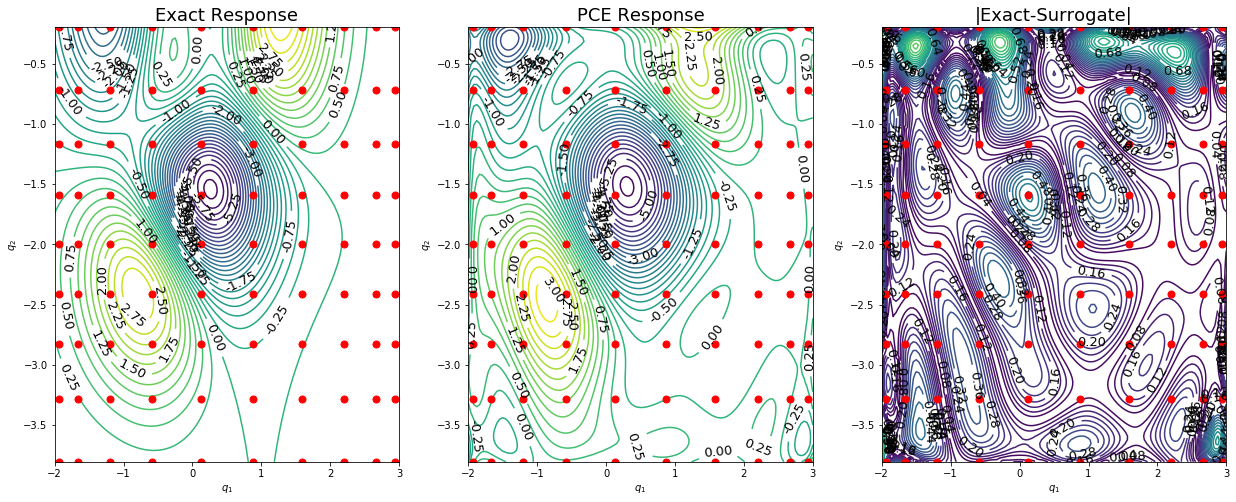

In [32]:
def plot2d(nTest,qTest,fTest,q,fPCE):
    # Create 2D grid from the test samples and plot the contours of response surface over it
    fTestGrid=fTest.reshape(nTest,order='F')
    fErrorGrid=(abs(fTestGrid-fPCE))
    # 2D grid from the sampled parameters
    if sampleType[0]=='LHS' and sampleType[1]=='LHS':
       qGrid=reshaper.vecsGlue(q[0],q[1])
    else:
       qGrid=reshaper.vecs2grid(q)
    plt.figure(figsize=(21,8));
    plt.subplot(1,3,1)
    ax=plt.gca()
    CS1 = plt.contour(qTest[0],qTest[1],fTestGrid.T,40)
    plt.clabel(CS1, inline=True, fontsize=13,colors='k',fmt='%0.2f',rightside_up=True,manual=False)
    plt.plot(qGrid[:,0],qGrid[:,1],'o',color='r',markersize=7)
    plt.xlabel(r'$q_1$');plt.ylabel(r'$q_2$')
    plt.title('Exact Response',fontsize=18)
    plt.subplot(1,3,2)
    ax=plt.gca()
    CS2 = plt.contour(qTest[0],qTest[1],fPCE.T,40)
    plt.clabel(CS2, inline=True, fontsize=13,colors='k',fmt='%0.2f',rightside_up=True,manual=False)
    plt.plot(qGrid[:,0],qGrid[:,1],'o',color='r',markersize=7)
    plt.xlabel(r'$q_1$');plt.ylabel(r'$q_2$')
    plt.title('PCE Response',fontsize=18)
    plt.subplot(1,3,3)
    ax=plt.gca()
    CS3 = plt.contour(qTest[0],qTest[1],fErrorGrid.T,40)
    plt.clabel(CS3, inline=True, fontsize=13,colors='k',fmt='%0.2f',rightside_up=True,manual=False)
    plt.xlabel(r'$q_1$');plt.ylabel(r'$q_2$')
    plt.plot(qGrid[:,0],qGrid[:,1],'o',color='r',markersize=7)
    plt.title('|Exact-Surrogate|',fontsize=18)
    plt.show()
    
plot2d(nTest,qTest,fTest,q,fPCE)    

Now, let's assume both parameters are uniformly distributed and use Latin-Hypercube Sampling (LHS). In this case, the number of samples becomes equal to `nQ[0]*nQ[1]`. The purpose of this example is to show we can use random parameter samples and large number of terms in the PCE. We need to the following changes in the settings:

In [33]:
distType=['Unif','Unif']   #distribution type of the parameters q1, q2
sampleType=['LHS','LHS']
qInfo=[[-3,3],             #info on parameters
       [-3,3]]
nQ=[20,22]                   #number of training samples of parameters 
if truncMethod=='TO':
   LMax=35   #max polynomial order in each parameter dimention

The `pceDict` is updated due to the new inputs:

In [34]:
p=len(distType)
pceDict={'p':p,'truncMethod':truncMethod,'sampleType':sampleType,
            'pceSolveMethod':pceSolveMethod,'distType':distType}
if truncMethod=='TO':
   pceDict.update({'LMax':LMax,'pceSolveMethod':'Regression'})

We can generate the training samples as below:

In [35]:
q=[]
qBound=qInfo
xi=sampling.LHS_sampling(nQ[0]*nQ[1],[[-1,1]]*p)
for i in range(p):
    q.append(pce.pce.mapFromUnit(xi[:,i],qBound[i]))
fEx_=analyticTestFuncs.fEx2D(q[0],q[1],fType,'comp')
fVal=fEx_.val
xiGrid=xi

The PCE is constructed exactly as above:

In [36]:
pce_=pce.pce(fVal=fVal,xi=xiGrid,pceDict=pceDict,nQList=nQ)
fMean=pce_.fMean
fVar=pce_.fVar
pceCoefs=pce_.coefs
kSet=pce_.kSet

... A gPCE for a 2-D parameter space is constructed.
...... PCE truncation method: TO
...... Method of computing PCE coefficients: Regression
         with LMax=35 as the max polynomial order in each direction.
...... Number of terms in PCE, K=  666
...... Number of Data point, n=  440
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 1332, constraints m = 1998
          nnz(P) + nnz(A) = 446218
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100000
          check_termination: on (interval 25),
          scaling: on, scaled_terminat

The convergence of the PCE terms:

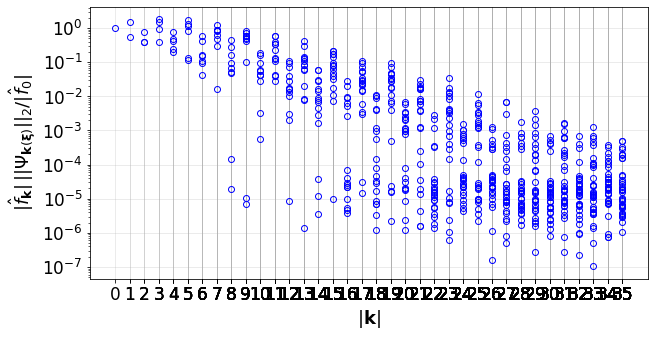

In [37]:
pce.convPlot(coefs=pceCoefs,distType=distType,kSet=kSet)

Let's evaluate the constructed PCE at the test samples

In [38]:
xiTest,qTest,fTest=testSamps2d(p,distType,qInfo,qBound,nTest)
pcePred_=pce.pceEval(coefs=pceCoefs,xi=xiTest,distType=distType,kSet=kSet)
fPCE=pcePred_.pceVal

We can compare the estimated mean and varaince of $f(q_1,q_2)$ with what we get from the Monte-Carlo approach:

In [39]:
fEx_.moments(distType,qInfo)
fMean_mc=fEx_.mean
fVar_mc=fEx_.var
print('------------ MC -------- PCE --------- Error % ')
print('Mean of f(q) = %g\t%g\t%g' %(fMean_mc,fMean,(fMean-fMean_mc)/fMean_mc*100.))
print('Var  of f(q) = %g\t%g\t%g' %(fVar_mc,fVar,(fVar-fVar_mc)/fVar_mc*100.))

... Reference moments are calculated by the Monte-Carlo method with 100000 samples
------------ MC -------- PCE --------- Error % 
Mean of f(q) = 0.353458	0.361014	2.13783
Var  of f(q) = 3.5984	3.6268	0.789187


Finally, the response surface can be plotted.

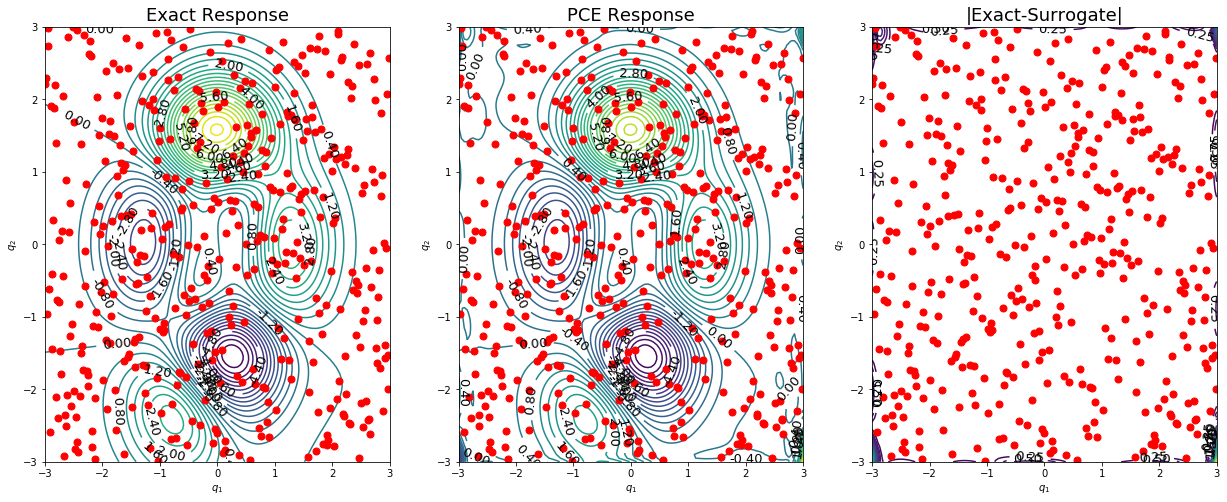

In [40]:
plot2d(nTest,qTest,fTest,q,fPCE)    

### Example 5: gPCE for 3 uniformly distributed parameters

Consider the [Ishigami](https://inis.iaea.org/search/search.aspx?orig_q=RN:21024954) function,

$$
\begin{equation}
f(\mathbf{q}) = \sin(q_1)+a\sin^2(q_2)+b\,q_3^4\sin(q_1) \,,
\end{equation}
$$

in which $q_i\sim \mathcal{U}[\mathbb{Q}_i]\,,i=1,2,3$.
The aim is to validate the estimated moments of $f(\mathbf{q})$ by `UQit` with the analytical reference values.

... A gPCE for a 3-D parameter space is constructed.
...... PCE truncation method: TO
...... Method of computing PCE coefficients: Regression
         with LMax=10 as the max polynomial order in each direction.
...... Number of terms in PCE, K=  286
...... Number of Data point, n=  120
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 572, constraints m = 858
          nnz(P) + nnz(A) = 81786
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 100000
          check_termination: on (interval 25),
          scaling: on, scaled_termination

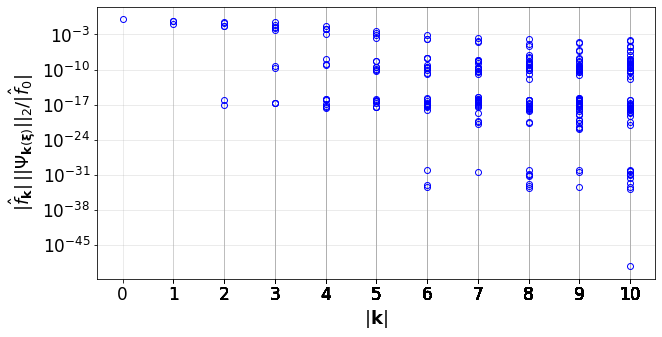

--------------------------------------------------
		 Exact 		 PCE
E[f]:   4.573160953235525 4.573189774327447
V[f]:   11.562474905206148 11.517012062432517
--------------------------------------------------


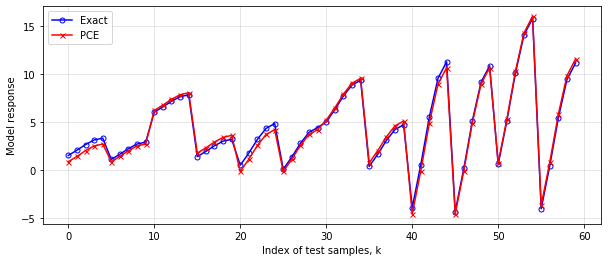

In [41]:
#Settings
distType=['Unif','Unif','Unif']   #distribution type of the parameters
qInfo=[[-0.75,1.5],               #range of parameters
       [-0.5,2.5],   
       [ 1.0,3.0]]   
nQ=[6,5,4]                        #number of parameter samples in the 3 dimensions
funOpt={'a':7,'b':0.1}            #parameters in the Ishigami function
#PCE options
truncMethod='TO'  #'TP'=Tensor Product
                  #'TO'=Total Order  
sampleType='GQ'   #'GQ'=Gauss Quadrature nodes
                  #other types: see trainSample in sampling.py
pceSolveMethod='Regression' #'Regression': for any combination of sample points and truncation methods
                            #'Projection': only for 'GQ'+'TP'
nTest=[5,4,3]   #number of test samples for the parameters                          
if truncMethod=='TO':
   LMax=10   #max polynomial order in each parameter direction
#--------------------
p=len(distType)
#Assemble the pceDict
pceDict={'p':p,'truncMethod':truncMethod,'sampleType':sampleType,'pceSolveMethod':pceSolveMethod,
         'distType':distType}
if truncMethod=='TO':
   pceDict.update({'LMax':LMax})
#Generate training data
xi=[]
q=[]
qBound=[]
for i in range(p):
    samps=sampling.trainSample(sampleType=sampleType,GQdistType=distType[i],qInfo=qInfo[i],nSamp=nQ[i])
    xi.append(samps.xi)
    q.append(samps.q)
    qBound.append(samps.qBound)
fEx=analyticTestFuncs.fEx3D(q[0],q[1],q[2],'Ishigami','tensorProd',funOpt)  
fVal=fEx.val
#Construct the PCE   
xiGrid=reshaper.vecs2grid(xi)
pce_=pce.pce(fVal=fVal,xi=xiGrid,pceDict=pceDict,nQList=nQ)
fMean=pce_.fMean
fVar=pce_.fVar
pceCoefs=pce_.coefs
kSet=pce_.kSet
#Convergence of the PCE terms
pce.convPlot(coefs=pceCoefs,distType=distType,kSet=kSet)
#Exact moments of the Ishigami function
fEx.moments(qInfo=qBound)
m=fEx.mean
v=fEx.var
#Compare the moments estimated by PCE with the exact analytical values
print(writeUQ.printRepeated('-',50))
print('\t\t Exact \t\t PCE')
print('E[f]:  ',m,fMean)
print('V[f]:  ',v,fVar)
print(writeUQ.printRepeated('-',50))
#Compare the PCE predictions at test points with the exact values of the model response
qTest=[]
xiTest=[]
for i in range(p):
    testSamps=sampling.testSample('unifSpaced',GQdistType=distType[i],qInfo=qInfo[i],qBound=qBound[i],nSamp=nTest[i])
    qTest.append(testSamps.q)
    xiTest.append(testSamps.xi)
fVal_test_ex=analyticTestFuncs.fEx3D(qTest[0],qTest[1],qTest[2],'Ishigami','tensorProd',funOpt).val  
#PCE prediction at test points
pcePred_=pce.pceEval(coefs=pceCoefs,xi=xiTest,distType=distType,kSet=kSet)
fVal_test_pce=pcePred_.pceVal
#Plot the exact and PCE response values 
nTest_=np.prod(np.asarray(nTest))
fVal_test_pce_=fVal_test_pce.reshape(nTest_,order='F')
err=np.linalg.norm(fVal_test_pce_-fVal_test_ex)
plt.figure(figsize=(10,4))
plt.plot(fVal_test_pce_,'-ob',mfc='none',ms=5,label='Exact')
plt.plot(fVal_test_ex,'-xr',ms=5,label='PCE')
plt.xlabel('Index of test samples, k')
plt.ylabel('Model response')
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()